# FUGW Barycenter

In [336]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main
    !pip install nilearn

In [337]:
from nilearn import datasets, image, plotting, surface

import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from ott.problems.quadratic import gw_barycenter as gwb
from ott.solvers.quadratic import gw_barycenter as gwb_solver

In [338]:
n_subjects = 4

contrasts = [
    "sentence reading vs checkerboard",
    "sentence listening",
    "calculation vs sentences",
    "left vs right button press",
    "checkerboard",
]
cmaps = datasets.fetch_localizer_contrasts(
    contrasts,
    n_subjects=n_subjects,
).cmaps

fsaverage3 = datasets.fetch_surf_fsaverage(mesh="fsaverage3")


def load_images_and_project_to_surface(image_paths):
    """Util function for loading and projecting volumetric images."""
    images = [image.load_img(img) for img in image_paths]
    surface_images = [
        jnp.nan_to_num(surface.vol_to_surf(img, fsaverage3.pial_left))
        for img in images
    ]

    return jnp.stack(surface_images).T


def load_surfacic_contrasts(cmaps, n_subjects):
    subject_list = [f"S0{i}" for i in range(n_subjects)]
    subjects_contrasts = {}

    for i, sub in enumerate(subject_list):
        image_paths = cmaps[i * len(contrasts) : (i + 1) * len(contrasts)]
        images = load_images_and_project_to_surface(image_paths)
        subjects_contrasts[sub] = images / jnp.max(images, axis=0)

    return subjects_contrasts


subjects_contrasts = load_surfacic_contrasts(cmaps, n_subjects)
subjects_contrasts["S00"].shape

/Users/plbar/micromamba/envs/ottenv/lib/python3.11/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/plbar/micromamba/envs/ottenv/lib/python3.11/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/plbar/micromamba/envs/ottenv/lib/python3.11/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/plbar/micromamba/envs/ottenv/lib/python3.11/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/plbar/micromamba/envs/ottenv/lib/python3.11/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/plbar/micromamba/envs/ottenv/lib/python3.11/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Me

(642, 5)

In [339]:
x, _ = surface.load_surf_mesh(fsaverage3.pial_left)
y = jnp.repeat(x[jnp.newaxis, ...], n_subjects, axis=0)
y_fused = jnp.array(list(subjects_contrasts.values()))

In [340]:
ndim = 3
ndim_f = len(contrasts)
n_points = x.shape[0]

b = jnp.ones((n_subjects, n_points)) / n_points

In [341]:
fused_penalty = 0.9
epsilon = 1e-2
tau_a = 0.9
tau_b = 0.9
rank = -1

prob = gwb.GWBarycenterProblem(
    y=y,
    b=b,
    y_fused=y_fused,
    fused_penalty=fused_penalty,
    scale_cost="max_cost",
    tau_a=tau_a,
    tau_b=tau_b,
    gw_unbalanced_correction=True,
)

In [342]:
solver = jax.jit(
    gwb_solver.GromovWassersteinBarycenter(
        epsilon=epsilon, rank=rank, max_iterations=5
    ),
    static_argnames="bar_size",
)
fugw = solver(prob, bar_size=n_points)

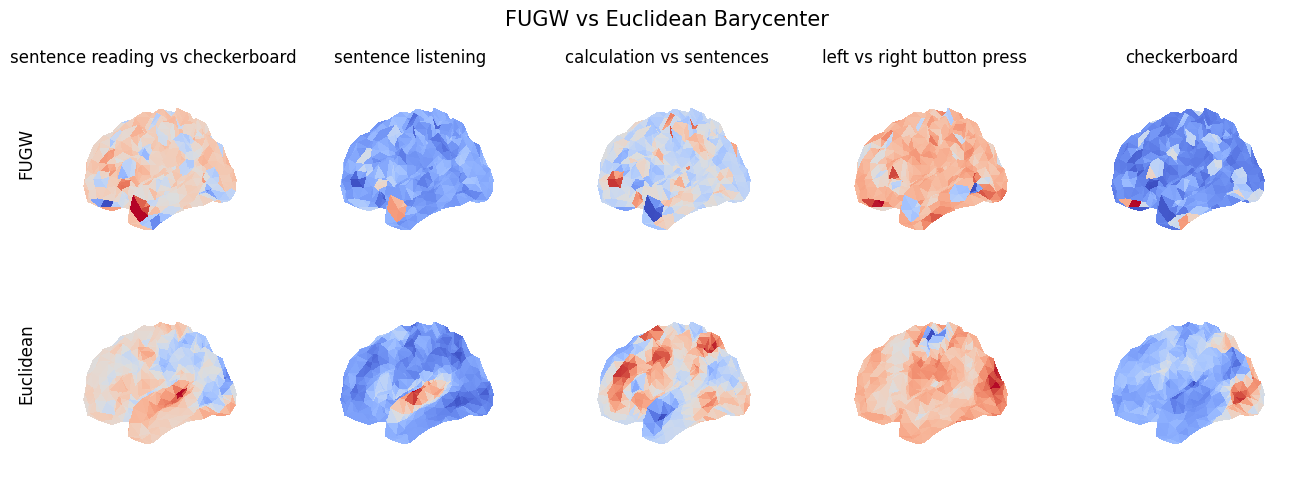

In [343]:
# For compatibility with nilearn
barycenter_f = np.asarray(fugw.x)
euclidean_f = np.asarray(y_fused)

fig = plt.figure(figsize=(13, 5))
fig.suptitle("FUGW vs Euclidean Barycenter", fontsize=15)
grid_spec = gridspec.GridSpec(2, 5, figure=fig)
for i, name in enumerate(contrasts):
    ax = fig.add_subplot(grid_spec[0, i], projection="3d")
    surf_map = barycenter_f[:, i]
    ax.set_title(name)
    plotting.plot_surf(
        fsaverage3.pial_left,
        surf_map,
        bg_map=fsaverage3.sulc_left,
        axes=ax,
        colorbar=False,
        cmap="coolwarm",
    )
    ax = fig.add_subplot(grid_spec[1, i], projection="3d")
    surf_map = euclidean_f.mean(axis=0)[:, i]
    plotting.plot_surf(
        fsaverage3.pial_left,
        surf_map,
        bg_map=fsaverage3.sulc_left,
        axes=ax,
        colorbar=False,
        cmap="coolwarm",
    )
fig.text(0.0, 0.65, "FUGW", fontsize=12, rotation=90)
fig.text(0.0, 0.2, "Euclidean", fontsize=12, rotation=90)
plt.tight_layout()